In [58]:
import pandas as pd
import numpy as np

import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')

import os
import shutil # shutil.rmtree

#-------------------- visualization (edcoding, grid) -----------

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# sns.set()


In [109]:
# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.layers import LSTM                              #-------------RNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
from PIL import Image


# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [60]:
import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler

# Lec06. LSTM을 활용한 주가 예측

yfinance # 주가 데이터(대량으로 가져오면 좀 느림)  
pandas_reader # 하이재킹 관계(가로챈다.) ->yfinance가 버벅거리면 얘가 가로채서 빨리 처리하  
FinanceDataReader  
pykrx # 국내 주가 데이터. 가벼워서 10년치 데이터 가져올 때 좋다.  

! pip install yfinance  
! pip install pandas-datareader  
! pip install Finance-DataReader  
! pip install pykrx  

-> 각각의 API가 작동하는 방식(어떤 건 대문자로 된 컬럼만 된다든가..)과 제공하는 정보가 다르기 때문에 다 알아두는 것이 좋다.

! pip install bokeh  
Finance-DataReader에서 그래프 그릴 때

## yfinance : yahoo fiance 에서 제공하는 금융 API
ref: https://pypi.org/project/yfinance/  

In [8]:
import yfinance as yf

# data download
data = yf.download("SPY AAPL", start="2017-01-01", end="2017-04-30") # 상장종목 코드(Ticker), 시작일, 끝일
data.head()

[*********************100%***********************]  2 of 2 completed


Adj Close                  Close                   High  \
                 AAPL         SPY       AAPL         SPY       AAPL   
Date                                                                  
2017-01-03  27.297691  206.147522  29.037500  225.240005  29.082500   
2017-01-04  27.267138  207.373947  29.004999  226.580002  29.127501   
2017-01-05  27.405806  207.209229  29.152500  226.399994  29.215000   
2017-01-06  27.711332  207.950546  29.477501  227.210007  29.540001   
2017-01-09  27.965153  207.264084  29.747499  226.460007  29.857500   

                              Low                   Open              \
                   SPY       AAPL         SPY       AAPL         SPY   
Date                                                                   
2017-01-03  225.830002  28.690001  223.880005  28.950001  225.039993   
2017-01-04  226.750000  28.937500  225.610001  28.962500  225.619995   
2017-01-05  226.580002  28.952499  225.479996  28.980000  226.270004   
2017-01-06  227.750000  29.117500  225.899994  29.195000  226.529999   
2017-01-09  227.070007  29.485001  226.419998  29.487499  226.910004   

               Volume            
                 AAPL       SPY  
Date                             
2017-01-03  115127600  91366500  
2017-01-04   84472400  78744400  
2017-01-05   88774400  78379000  
2017-01-06  127007600  71559900  
2017-01-09  134247600  46939700

-> OHLCV(Open High Low Close Volume) 데이터 준다.  
Adj Close : 액면분할 했을 때의 가격. 수정종가.(수익률 보려면 이걸로 해야한다.? 나중에 설명)
            여기 맞춰서 open, high, low 비율 맞춰서 다시 계산해야됨.

## pandas-datareader  
ref: https://pandas-datareader.readthedocs.io/en/latest/

In [9]:
# hijack 걸릴 때
from pandas_datareader import data as pdr # pandas datareader라고 써있지만 상위는 yfinance 갔다 온 거임.
yf.pdr_override() # hijack 가능하도록 override설정.

# download dataframe
data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,206.147537,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,207.373932,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,207.209183,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,207.950516,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,207.264114,46939700


## Finance-DataRearder
ref: https://github.com/FinanceData/FinanceDataReader  
강사님 주로 사용. 국내에서 만들어짐.

In [10]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
dfss = fdr.DataReader('005930') #, '1980-01-01', '2019-12-30'
print(dfss.shape)
dfss.head() # Close : 자체가 수정종가
        # -> 여기에 맞춰서 Open, High, Low, CLose 계산할 필요 없다. change 따로 계산할 필요도 없다.

(6000, 6)


,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-01-21,1388,1388,1283,1320,1163080,NaN
1998-01-22,1307,1325,1214,1215,905730,-0.079545
1998-01-23,1234,1263,1200,1262,616720,0.038683
1998-01-24,1288,1361,1270,1362,467950,0.079239
1998-01-26,1377,1468,1377,1461,1244670,0.072687


In [11]:
stocks = fdr.StockListing('KOSDAQ') # StockListing : Ticker list 반환

In [13]:
stocks.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도
5,211270,KOSDAQ,AP위성,통신 및 방송 장비 제조업,위성통신 단말기,2016-03-04,12월,류장수,http://www.apsi.co.kr,서울특별시
52,032790,KOSDAQ,BNGT,기계장비 및 관련 물품 도매업,"Bio 이종장기 사업, ICT 프린터 현상기",1997-06-26,12월,조상환,http://www.mgenplus.com,서울특별시


## pykrx
ref:https://github.com/sharebook-kr/pykrx  
-> 한글로 준다. 불편  
-> Naver 크롤링 해서 준다.(네이버가 사이트 개편하면 pykrx 일정 기간 먹통 됨)

In [15]:
from pykrx import stock # 주가
from pykrx import bond  # 채권

In [19]:
df = stock.get_market_ohlcv("20150720", "20150810", "005930")
df.head(3)

,시가,고가,저가,종가,거래량
날짜,,,,,
2015-07-20,25820,26080,25460,25500,128928
2015-07-21,25500,25540,24940,25260,194055
2015-07-22,24880,25200,24700,25060,268323


In [17]:
tickers = stock.get_market_ticker_list("20190225") # 리스트 비교해서 어떤 기간 사이에 상폐 된 애 있는지 관리할 때 편함.
tickers[:5]

['095570', '068400', '006840', '027410', '282330']

# 삼성전자 약 25년 주가 정보 가져오기

In [21]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
dfss = fdr.DataReader('005930') #, '1980-01-01', '2019-12-30'
print(dfss.shape)
dfss.head() # Close : 자체가 수정종가
        # -> 여기에 맞춰서 Open, High, Low, CLose 계산할 필요 없다. change 따로 계산할 필요도 없다.

(6000, 6)


,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-01-21,1388,1388,1283,1320,1163080,NaN
1998-01-22,1307,1325,1214,1215,905730,-0.079545
1998-01-23,1234,1263,1200,1262,616720,0.038683
1998-01-24,1288,1361,1270,1362,467950,0.079239
1998-01-26,1377,1468,1377,1461,1244670,0.072687


<AxesSubplot:xlabel='Date'>

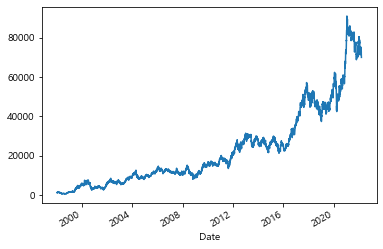

In [22]:
dfss['Close'].plot()

In [27]:
# 캔들차트 그리기
df = fdr.DataReader('005930', '2021-01-01', '2021-02-15')

# 차트 설정
config = {'title':'fdr.chart.config()를 사용하여 설정을 한번에 지정할 수 있습니다', 
          'width': 600, 
          'height': 300,
          'volume': True,
}

fdr.chart.config(config=config)
fdr.chart.plot(df)

Loading BokehJS ...

# 전처리 & 가공

In [47]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [204]:
dfss=dfss.loc['2015-09-01' : '2016-12-31'].copy() # 2015-09-01 ~ 2015-12-31은 패딩 데이터

In [205]:
mms = MinMaxScaler()
dfss_scaled = mms.fit_transform(dfss)

In [206]:
dfss_scaled = pd.DataFrame(dfss_scaled, columns = dfss.columns)
dfss_scaled.head()

,Open,High,Low,Close,Volume,Change
0,0.235616,0.182209,0.164095,0.115160,0.185554,0.287642
1,0.156164,0.121951,0.137447,0.119534,0.107065,0.649212
2,0.164384,0.107604,0.112202,0.071429,0.237179,0.415631
3,0.106849,0.071736,0.088359,0.053936,0.164363,0.549672
4,0.102740,0.076040,0.105189,0.065598,0.143109,0.683606


## 강사님

In [207]:
dfss['Close'].values # Series를 array로 바꾸는 가장 쉬운 방법
scaler = MinMaxScaler()
scaler.fit(dfss['Close'].values.reshape(-1,1)) # 세로줄 array가 필요. Series는 array가 안 된다.
                                             # fit은 결과 내보내는 게 아니다.
res = scaler.transform(dfss['Close'].values.reshape(-1,1))
print(res[:5])

[[0.11516035]
 [0.11953353]
 [0.07142857]
 [0.05393586]
 [0.06559767]]


In [ ]:
# 이런 식으로 해도 되는데 귀찮다.

# scaler= MinMaxScaler()
# for col in dfss.columns():
#     scaler.fit(dfss['Close'].values.reshape(-1,1)) # 세로줄 array가 필요. Series는 array가 안 된다.
#                                                  # fit은 결과 내보내는 게 아니다.
#     res = scaler.transform(dfss['Close'].values.reshape(-1,1))
#     print(res[:5])

In [56]:
# 전체 데이터 프레임에 대해 하면 된다.
# scaler = MinMaxScaler()
# dfss_scaled = scaler.fit_transform(dfss)

# # fit 할 때는 그냥 array로 줘도 되는데 데이터 핸들링 연습하려고 데이터프레임화 시켰다.
# dfss_scaled = pd.DataFrame(dfss_scaled, columns = dfss.columns) 
# dfss_scaled.head()

,Open,High,Low,Close,Volume,Change
0,0.015371,0.014339,0.014335,0.007547,0.012879,NaN
1,0.014474,0.013688,0.013564,0.006385,0.010030,0.201765
2,0.013666,0.013048,0.013408,0.006906,0.006829,0.612900
3,0.014264,0.014060,0.014190,0.008012,0.005182,0.753932
4,0.015249,0.015165,0.015385,0.009108,0.013783,0.731148


## 이동평균 파생변수

In [212]:
# 이동평균 이렇게 그리면 이동평균 한 만큼 널 생김 -> 패딩데이터 필요하다.(3개월 이동평균을 2016년부터 할 거면 2015년 9월 데이터까지는 가져와야 됨.)
dfss_scaled['ma5'] = dfss_scaled['Close'].rolling(5).mean() # 5일 moving average 1주
dfss_scaled['ma20'] = dfss_scaled['Close'].rolling(20).mean() # 20일 moving acerage 1달
dfss_scaled['ma60'] = dfss_scaled['Close'].rolling(60).mean() # 60일 moving acerage 3달
# dfss['ma120'] = dfss['Close'].rolling(120).mean() # 120일 moving acerage 6달

In [213]:
dfss_scaled = dfss_scaled.dropna(axis=0)

In [214]:
dfss_scaled.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
ma5       0
ma20      0
ma60      0
dtype: int64

In [215]:
dfss_scaled.head()

,Open,High,Low,Close,Volume,Change,ma5,ma20,ma60
59,0.298630,0.259613,0.294530,0.271137,0.250871,0.653667,0.251312,0.194388,0.101336
60,0.289041,0.252511,0.256662,0.223032,0.154669,0.432600,0.248688,0.199052,0.103134
61,0.261644,0.246772,0.267882,0.260933,0.082936,0.789002,0.251895,0.205029,0.105491
62,0.289041,0.238164,0.241234,0.195335,0.124601,0.359485,0.243149,0.209985,0.107556
63,0.247945,0.226686,0.252454,0.231778,0.079645,0.785185,0.236443,0.216618,0.110520


## 시간으로 time, train 나누기. 슬라이딩 데이터 생성(window_size)
Flatten된 걸 CNN에서 28*28 이런 식으로 변형한 거랑 비슷

In [61]:
dfss.shape

(6000, 6)

In [ ]:
# 결측 채우는 다른 방법

# 금융
# 결측 앞에 있을 때 : 0처리
# 결측 중간에 있을 때 : 

# dfss = dfss.fillna(method = 'bfill')
# dfss = dfss.fillna(method = 'ffill')

In [216]:
window_size = 20
test_size = 26

# train = dfss.iloc[1:-test_size, :] # 1: 인 이유는 change의 첫행이 결측이기 때문

dfss = dfss.fillna(method = 'bfill')

train = dfss.iloc[:-test_size, :]
test = dfss.iloc[-test_size:, :]

train.shape, test.shape

((161, 9), (26, 9))

In [76]:
# 연습용
# 왜 그냥 train 안 하고 이렇게 할까? -> windowisze 빼야해서
# traincp=train.iloc[:30,:].copy()
# X_list = []
# y_list = []

# for i in range(len(traincp) - window_size):
#     X_train=traincp.iloc[i : i+window_size, :]
#     y_train=traincp.iloc[i+window_size, :]
#     X_list.append(X_train)
#     y_list.append(y_train)
#     # print(X_train.shape, y_train.shape)
# X_arr = np.array(X_list)
# y_arr = np.array(y_list)
# print(X_arr.shape, y_arr.shape)

(10, 20, 6) (10, 6)


In [ ]:
# 내 버전 1

# def my_window_data(df, target, window_size=20):
#     X=df.drop([target], axis=1)
#     y=df[target]

#     X_list = []
#     y_list = []

#     for i in range(len(df) - window_size):
#         X_train=X.iloc[i : i+window_size, :]
#         y_train=y.iloc[i+window_size]
#         X_list.append(X_train)
#         y_list.append(y_train)
#         # print(X_train.shape, y_train.shape)
#     X_arr = np.array(X_list)
#     y_arr = np.array(y_list)
#     return X_arr, y_arr

In [123]:
def my_window_data(df_X, df_y, window_size=20):
    X_list = []
    y_list = []

    for i in range(len(df_X) - window_size):
        X_train=df_X.iloc[i : i+window_size, :]
        y_train=df_y.iloc[i+window_size]
        X_list.append(X_train)
        y_list.append(y_train)
        # print(X_train.shape, y_train.shape)
    return np.array(X_list), np.array(y_list)

In [192]:
# 여러 피쳐로 종가를 예측해보자 -> 주식 가격이 close맞 가지고 결정되는 게 아니기 때문.
dfss.columns
X_col = ['Open', 'High', 'Low', 'Volume', 'Change']
y_col = ['Close']

# X_train, y_train = my_window_data(train, 'Close', window_size=20)
X_train, y_train = my_window_data(train[X_col], train[y_col], window_size=20)
print(X_train.shape, y_train.shape)

X_test, y_test = my_window_data(test[X_col], test[y_col], window_size=20)
print(X_test.shape, y_test.shape)

(200, 20, 5) (200, 1)
(6, 20, 5) (6, 1)


In [190]:
X_train.shape[1:]

(20, 5)

In [193]:
# many_to_one 구조 : 그래서 굳이 Flatten화 시킬 필요 업다.

# gru로 하고 싶으면 LSTM을 GRU로, BiLSTM하고 싶으면 BiLSTM쓰면 된다.
lstm= LSTM(units =16, # 내보내는 개수
               input_shape = (X_train.shape[1:]), # 4980개 넣는 거 아니다. (X_train.shape[1], X_train.shape[2])로 써도 된다.
                activation = 'tanh',
                recurrent_activation = 'sigmoid',
                dropout=0.0,
                recurrent_dropout = 0.0,
                return_sequences=True) # sequence내뱉는 걸 다음 놈한테 줄 거냐 말 거냐. True(many to many)는 뒷레이어한테도 준다. False면 옆 놈한테만 준다.(many to one)
                                       # LSTM에서 LSTM 넘길 때는 return_sequences = True로 줘야 하나봐(many to many라)

model = Sequential()
model.add(lstm)
# model.add(LSTM()) # hidden도 필요 없다. feature 여러 개 만들면 알아서 feature 안에서 deep하게 움직여서 출력값 뿌리는 거라.
# model.add(LSTM())
# model.add(LSTM())

model.add(LSTM(units = 8, return_sequences=True)) # 근데 결과 너무 안 좋아서... 추가..

model.add(Dense(1, ))

In [194]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 20, 16)            1408      
                                                                 
 lstm_18 (LSTM)              (None, 20, 8)             800       
                                                                 
 dense_8 (Dense)             (None, 20, 1)             9         
                                                                 
Total params: 2,217
Trainable params: 2,217
Non-trainable params: 0
_________________________________________________________________


In [195]:
model.compile(loss='mse',
             optimizer='adam',
             # metrics='mse' # 점수 뭘로 볼지 설정하는 건데 회귀에서는 loss랑 같은 거 써서 ㅐㅇ략.
             )

In [219]:
if os.path.exists("model"):
    shutil.rmtree("model")

In [196]:
import os
import shutil

if os.path.exists("./model"):
    shutil.rmtree("./model")

if not os.path.exists("./model"):
    os.mkdir('./model')
    
# os.direxists(os.path.join(os.getcwd()), 'new_folder')
# if not os.direxists('model'):
#     os.mkdir('model')

In [197]:
stop = EarlyStopping(patience=5, monitor = 'val_loss')


check_point = ModelCheckpoint(filepath='./model/lstm_{epoch:02d}_{val_loss:.4f}.h5',
                    monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                    save_best_only=True,         #------------이전보다 좋아질때만 저장
                    save_weights_only=False      #------------모델+가중치 같이 저장
                   )


res=model.fit(X_train, y_train,
          callbacks=[stop, check_point],
         epochs = 100,
         batch_size = 32,
         validation_split = 0.2)

Epoch 1/100
5/5 [==============================] - 3s 152ms/step - loss: 773342784.0000 - val_loss: 1032688000.0000
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 773338240.0000 - val_loss: 1032682688.0000
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 773333696.0000 - val_loss: 1032677504.0000
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 773329216.0000 - val_loss: 1032672448.0000
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 773324928.0000 - val_loss: 1032667328.0000
Epoch 6/100
5/5 [==============================] - 0s 16ms/step - loss: 773320576.0000 - val_loss: 1032662400.0000
Epoch 7/100
5/5 [==============================] - 0s 16ms/step - loss: 773316224.0000 - val_loss: 1032657280.0000
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 773311872.0000 - val_loss: 1032652288.0000
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 7733075

# 학습 과정 시각화

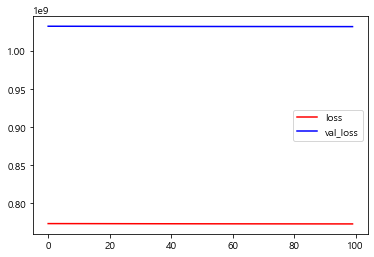

In [198]:
plt.plot(np.arange(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# plt.plot(np.arange(len(res1.history['accuracy'])), res1.history['accuracy'], c='red', label='loss')
# plt.plot(np.arange(len(res1.history['val_accuracy'])), res1.history['val_accuracy'], c='blue', label='val_loss')
# plt.legend()
# plt.show()

In [200]:
pred = model.predict(X_test)
print(pred.shape, y_test.shape)

(6, 20, 1) (6, 1)


In [201]:
pred, y_test

(array([[[2.40947  ],
         [5.234636 ],
         [7.2716427],
         [7.9095125],
         [8.043504 ],
         [8.067904 ],
         [8.072301 ],
         [8.072512 ],
         [8.073202 ],
         [8.072703 ],
         [8.073247 ],
         [8.073335 ],
         [8.073347 ],
         [8.073349 ],
         [8.073347 ],
         [8.073338 ],
         [8.073347 ],
         [8.073338 ],
         [8.073263 ],
         [8.072715 ]],
 
        [[2.40947  ],
         [5.735089 ],
         [7.6005893],
         [7.993048 ],
         [8.058922 ],
         [8.070574 ],
         [8.072695 ],
         [8.073212 ],
         [8.073234 ],
         [8.073328 ],
         [8.073346 ],
         [8.073349 ],
         [8.073349 ],
         [8.07335  ],
         [8.073347 ],
         [8.073349 ],
         [8.073347 ],
         [8.073338 ],
         [8.073263 ],
         [8.072715 ]],
 
        [[3.521573 ],
         [6.751138 ],
         [7.839867 ],
         [8.033154 ],
         [8.065926 ],
    

# 예측

ValueError: x and y can be no greater than 2D, but have shapes (6,) and (6, 20, 1)

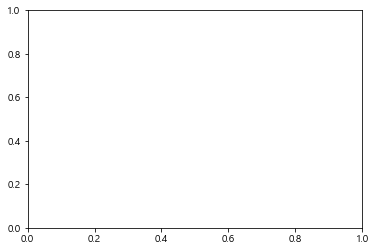

In [203]:
plt.plot(np.arange(pred.shape[0]), pred, c='red', label='pred') # 뭔가 잘못된 상태
plt.plot(np.arange(pred.shape[0]), y_test, c='blue', label='real')
plt.legend()
plt.show()

갈수록 오차 커진다. -> 2016년 이후 우상향 하는 형태 커지기 때문(정상데이터가 아니다.)
-> ARIMA로 차분 해서 정상 데이터로 만들고 다른 모델 만든다.

In [ ]:
# 답지 내려면 scaler.inverse_transform() 해서 원상복구 해야됨.
# 지금은 scaler하나로 다 scaling 해서 피쳐 따로 y 따로 스케일링 하면 에러남.
# 애초에 스케일링 할 때 피쳐만 scaling 하는 것과 target만 scaling하는 것 따로 만들거나
